In [2]:
!pip install lifelines
# Import core libraries for data manipulation and visualization
from matplotlib.pyplot import subplots  # For creating figure and axis objects for plotting
import numpy as np  # Numerical computing library for array operations
import pandas as pd  # Data manipulation library for DataFrames
from ISLP.models import ModelSpec as MS  # Model specification tool for creating design matrices

# Import survival analysis tools from the lifelines package
from lifelines import (
    KaplanMeierFitter,  # Fits Kaplan-Meier survival curves (non-parametric estimator)
    CoxPHFitter  # Fits Cox Proportional Hazards models (semi-parametric regression)
)
from lifelines.statistics import (
    logrank_test,  # Tests equality of survival curves between 2 groups
    multivariate_logrank_test  # Tests equality of survival curves among 3+ groups
)

print("All libraries imported successfully!")


All libraries imported successfully!


In [3]:
# Set random seed for reproducibility (following ISLP lab convention)
rng = np.random.default_rng(2025)

# Simulate 500 employees hired over a 5-year period
n_employees = 500

# Department assignment (5 departments with realistic proportions)
# Engineering is largest, HR smallest (typical for tech companies)
departments = rng.choice(
    ['Engineering', 'Sales', 'Marketing', 'HR', 'Operations'], 
    size=n_employees, 
    p=[0.40, 0.25, 0.18, 0.08, 0.09]
)

# Years of prior work experience at hire (0-20 years)
# Use exponential distribution to create right-skewed realistic experience levels
experience = rng.exponential(scale=4.5, size=n_employees)
experience = np.clip(experience, 0, 20)

# Performance rating (1.0-5.0 scale, where higher is better)
# Centered at 3.5 with standard deviation of 0.7 to create realistic distribution
performance = rng.normal(loc=3.5, scale=0.7, size=n_employees)
performance = np.clip(performance, 1.0, 5.0)

# Starting salary in thousands (correlated with experience and department)
# Different departments have different base salary structures
dept_salary_base = {
    'Engineering': 95,  # Highest base (competitive tech market)
    'Sales': 72,        # Lower base but typically has commission
    'Marketing': 78,    # Moderate base
    'HR': 68,           # Lower base
    'Operations': 85    # Good base (technical operations)
}
base_salary = np.array([dept_salary_base[d] for d in departments])
# Add experience premium (~$2.5k per year) plus random variation
salary = base_salary + 2.5 * experience + rng.normal(0, 8, n_employees)
salary = np.clip(salary, 45, 160)

# Remote work assignment (binary: 1 = remote, 0 = on-site)
# Engineering has highest remote proportion, Operations lowest
remote_prob = np.where(
    departments == 'Engineering', 0.60,  # Engineering: 60% remote
    np.where(departments == 'Operations', 0.15,  # Operations: 15% remote
             np.where(departments == 'Sales', 0.40,  # Sales: 40% remote
                     np.where(departments == 'Marketing', 0.45, 0.35)))  # Marketing: 45%, HR: 35%
)
remote_work = rng.binomial(1, remote_prob)

print("Covariates generated successfully!")
print(f"Sample size: {n_employees} employees")
print(f"Remote work proportion: {remote_work.mean():.1%}")

Covariates generated successfully!
Sample size: 500 employees
Remote work proportion: 45.2%


In [4]:
# Simulate employment duration (time until departure) using Cox model structure
# Different departments have different baseline retention patterns
dept_hazard_effects = {
    'Engineering': -0.40,   # Best retention (negative = lower hazard)
    'Sales': 0.45,          # Worst retention (positive = higher hazard)
    'Marketing': 0.18,      # Moderate-poor retention
    'HR': 0.08,             # Moderate retention
    'Operations': -0.25     # Good retention
}
dept_effect = np.array([dept_hazard_effects[d] for d in departments])

# Calculate hazard rate (risk of leaving) based on multiple factors
# Cox model structure: λ(t) = λ₀(t) × exp(β₁X₁ + β₂X₂ + ...)
# Protective factors (negative coefficients): experience, performance, salary, remote work
log_hazard = (
    dept_effect +                          # Department effect
    -0.10 * experience +                   # Each year experience reduces hazard by 9.5% (exp(-0.10)≈0.905)
    -0.40 * (performance - 3.5) +          # Higher performance is strongly protective
    -0.018 * (salary - 85) +               # Higher salary reduces departure risk
    -0.35 * remote_work +                  # Remote work reduces hazard by 30% (exp(-0.35)≈0.70)
    -1.5                                   # Baseline log-hazard
)
lambda_hazard = np.exp(log_hazard)  # Convert to hazard rate

# Generate time to departure from exponential distribution (months)
# Exponential distribution is memoryless and commonly used in survival simulation
time_to_departure = rng.exponential(scale=1/lambda_hazard, size=n_employees)

# Add administrative censoring (employees still at company at study end)
# Study duration varies by employee (12-60 months observation window)
# This creates realistic Type I censoring
study_duration = rng.uniform(low=12, high=60, size=n_employees)

# Observed time is minimum of departure time and censoring time
observed_time = np.minimum(time_to_departure, study_duration)
# Event indicator: 1 = departed (event observed), 0 = still employed (censored)
event_indicator = (time_to_departure <= study_duration).astype(int)

print(f"Survival times generated!")
print(f"Events (departures): {event_indicator.sum()}")
print(f"Censored (still employed): {(1 - event_indicator).sum()}")
print(f"Censoring rate: {(1 - event_indicator).mean():.1%}")

Survival times generated!
Events (departures): 433
Censored (still employed): 67
Censoring rate: 13.4%


In [5]:
# Create final DataFrame with all variables
retention_data = pd.DataFrame({
    'time': observed_time,                    # Employment duration in months
    'event': event_indicator,                 # 1 = left company, 0 = still employed
    'department': pd.Categorical(departments), # Department (categorical)
    'experience': experience,                 # Years of prior experience (continuous)
    'performance': performance,               # Performance rating 1-5 (continuous)
    'salary': salary,                         # Starting salary in thousands (continuous)
    'remote_work': remote_work                # 1 = remote, 0 = on-site (binary)
})

print("=" * 70)
print("EMPLOYEE RETENTION DATASET CREATED")
print("=" * 70)
print(f"Dataset dimensions: {retention_data.shape[0]} employees × {retention_data.shape[1]} variables")
print(f"\nFirst 10 observations:")
print(retention_data.head(10))

EMPLOYEE RETENTION DATASET CREATED
Dataset dimensions: 500 employees × 7 variables

First 10 observations:
        time  event   department  experience  performance      salary  \
0   4.137837      1   Operations    0.841920     2.655509   92.316205   
1   3.282764      1  Engineering    0.946957     3.380019   92.603354   
2  18.432079      1    Marketing    9.409169     2.735693   98.144888   
3   4.663205      1           HR    5.583752     2.030922   76.167897   
4   2.323511      1   Operations    0.686558     3.539874   79.926189   
5  14.018088      1  Engineering    2.070775     3.140689  104.693788   
6  39.645606      0  Engineering   15.157682     4.367160  138.590670   
7   4.476022      1   Operations    3.327090     3.320088   81.560671   
8   4.057824      1    Marketing    2.883564     3.737368   96.047723   
9  16.240357      0  Engineering   15.727998     3.492641  123.907938   

   remote_work  
0            0  
1            1  
2            1  
3            1  
4   

In [7]:
# Part 1(a) — Basic dataset summary

# 1. Dimensions
print("Dataset dimensions (rows, columns):", retention_data.shape)

print("\n==============================")
print("Event Counts (Departures vs Censored)")
print("==============================")
print(retention_data['event'].value_counts())

print("\n==============================")
print("Summary Statistics (Numerical Variables)")
print("==============================")
print(retention_data.describe())

print("\n==============================")
print("Department Distribution")
print("==============================")
print(retention_data['department'].value_counts())


Dataset dimensions (rows, columns): (500, 7)

Event Counts (Departures vs Censored)
event
1    433
0     67
Name: count, dtype: int64

Summary Statistics (Numerical Variables)
             time       event  experience  performance      salary  \
count  500.000000  500.000000  500.000000   500.000000  500.000000   
mean    10.339598    0.866000    4.284919     3.452507   93.746751   
std     11.332352    0.340993    4.170704     0.660430   16.430186   
min      0.005248    0.000000    0.008826     1.000000   54.329336   
25%      2.256432    1.000000    1.239732     3.052519   81.552871   
50%      6.298536    1.000000    3.092920     3.447376   93.424841   
75%     14.660414    1.000000    5.902214     3.868776  104.411944   
max     59.173154    1.000000   20.000000     5.000000  143.837352   

       remote_work  
count   500.000000  
mean      0.452000  
std       0.498189  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       1.000000  
max       1.000000  

Dep

In [8]:
# Part 1(b) — Fit Kaplan-Meier Estimator for overall retention
# Initialize KM estimator
kmf = KaplanMeierFitter()  

# Fit the model using time and event
kmf.fit(
    durations=retention_data['time'],
    event_observed=retention_data['event'],
    label="Overall Employee Retention"
)

print("Kaplan-Meier model fitted successfully!")


Kaplan-Meier model fitted successfully!


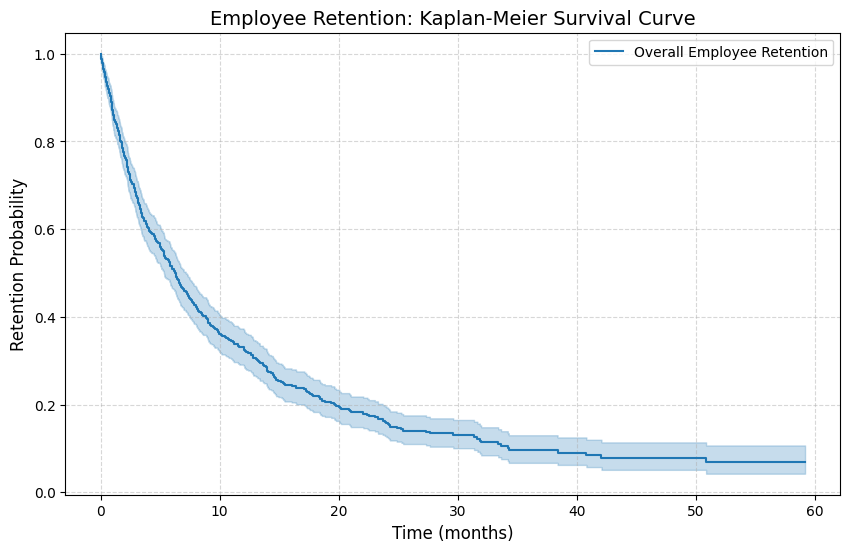

In [9]:
# Part 1(c) — Plot Kaplan-Meier survival curve with CI shading

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

kmf.plot_survival_function(ci_show=True)  # CI shading enabled by default

plt.title("Employee Retention: Kaplan-Meier Survival Curve", fontsize=14)
plt.xlabel("Time (months)", fontsize=12)
plt.ylabel("Retention Probability", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


In [10]:
# Part 1(d) — Key Survival Metrics

print("===== Retention Time Percentiles =====")

# Median retention time
median_time = kmf.median_survival_time_
print(f"Median Retention Time: {median_time:.2f} months")

# 25th and 75th percentiles
pct25 = kmf.percentile(0.25)
pct75 = kmf.percentile(0.75)
print(f"25th Percentile Retention Time: {pct25:.2f} months")
print(f"75th Percentile Retention Time: {pct75:.2f} months")

print("\n===== Retention Probability at Key Months =====")

ret_12 = kmf.predict(12)
ret_24 = kmf.predict(24)
ret_48 = kmf.predict(48)
print(f"Retention Probability at 12 months: {ret_12:.3f}")
print(f"Retention Probability at 24 months: {ret_24:.3f}")
print(f"Retention Probability at 48 months: {ret_48:.3f}")


===== Retention Time Percentiles =====
Median Retention Time: 6.29 months
25th Percentile Retention Time: 15.34 months
75th Percentile Retention Time: 2.26 months

===== Retention Probability at Key Months =====
Retention Probability at 12 months: 0.332
Retention Probability at 24 months: 0.161
Retention Probability at 48 months: 0.079


/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(
/opt/anaconda3/envs/myenv/lib/python3.11/site-packages/lifelines/fitters/__init__.py:279: ApproximationWarning: Approximating using `survival_function_`. To increase accuracy, try using or increasing the resolution of the timeline kwarg in `.fit(..., timeline=timeline)`.

  warnings.warn(


## **Part 1(e) — Interpretation**

### **Overall Interpretation**

The Kaplan-Meier curve shows that employee retention drops very quickly. The steepest decline happens in the first **6–12 months**, which aligns with the median retention time of only **6.3 months**. In other words, half of all employees leave within their first half-year at the company.

The retention percentiles also highlight how uneven the workforce is:

- **75th percentile ≈ 2.3 months** — A quarter of employees leave almost immediately after joining.
- **25th percentile ≈ 15.3 months** — Another group stays for more than a year.

This suggests that there are two distinct patterns: early quitters and longer-term stayers.

### **Retention at Key Time Points**

- **12-month retention:** 33%  
- **24-month retention:** 16%  
- **48-month retention:** 8%  

These numbers show that most turnover happens early, and by the second year, only a small portion of employees is still with the company.

---

## **What This Means for HR**

The steep early decline in retention suggests the company has an early-tenure turnover issue. Since many employees leave within the first 6–12 months, HR should focus on improving the new-hire experience. Key actions include:

- Strengthening onboarding  
- Providing clearer role expectations  
- Offering early mentorship or check-ins  

Overall, the results show that investing in early employee support could meaningfully improve retention and reduce rehiring and training costs.


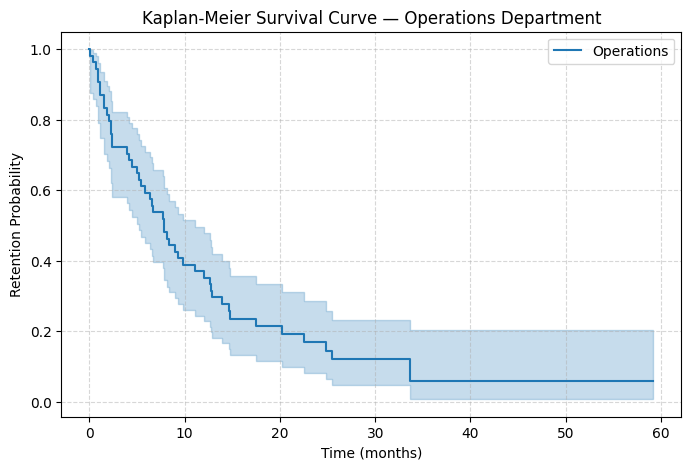

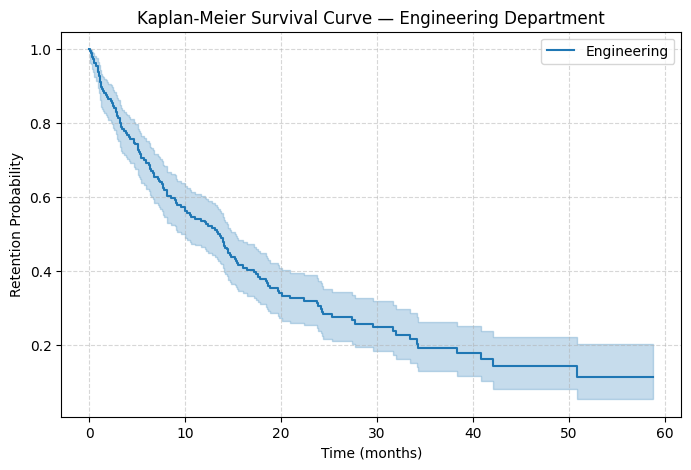

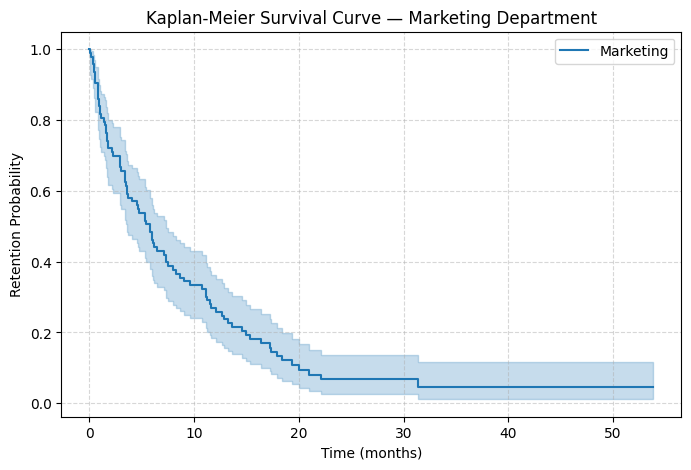

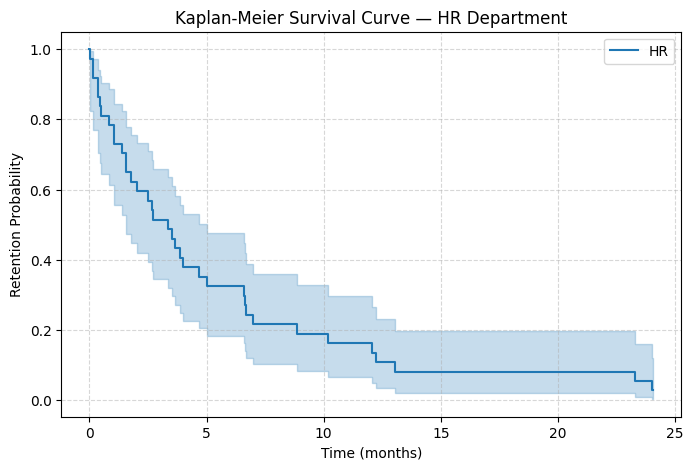

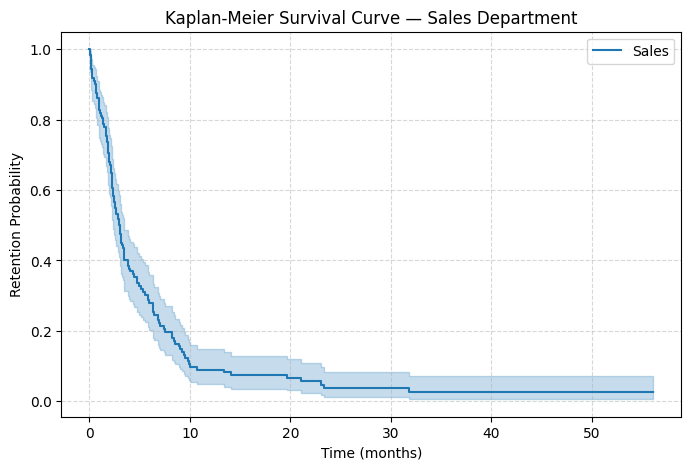

In [11]:
# Part 2(a) — Stratified Kaplan-Meier curves by department

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

departments = retention_data["department"].unique()

for dept in departments:
    kmf = KaplanMeierFitter()

    # Subset data for the current department
    df_sub = retention_data[retention_data["department"] == dept]

    # Fit KM curve
    kmf.fit(
        durations=df_sub["time"],
        event_observed=df_sub["event"],
        label=f"{dept}"
    )

    # Plot curve for this department
    plt.figure(figsize=(8, 5))
    kmf.plot_survival_function(ci_show=True)
    plt.title(f"Kaplan-Meier Survival Curve — {dept} Department")
    plt.xlabel("Time (months)")
    plt.ylabel("Retention Probability")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


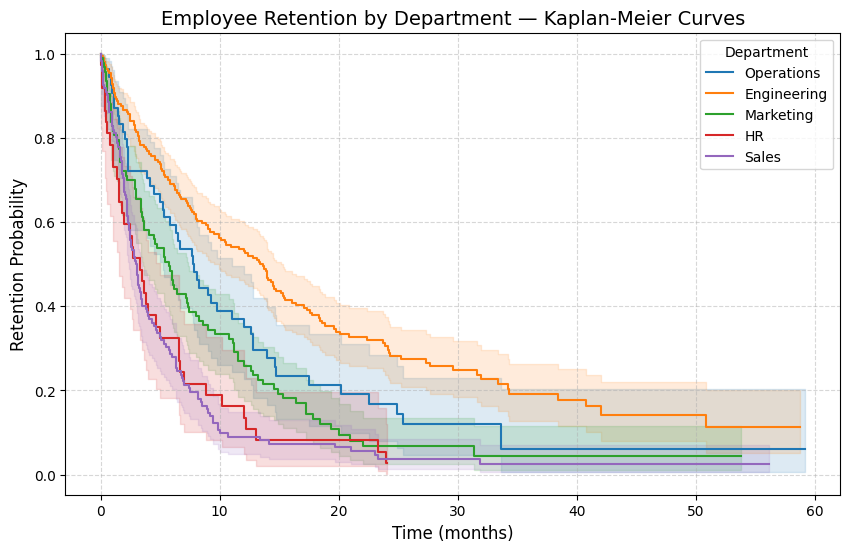

In [12]:
# Part 2(b) — All department survival curves in a single figure

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
departments = retention_data["department"].unique()

plt.figure(figsize=(10, 6))

for dept in departments:
    df_sub = retention_data[retention_data["department"] == dept]

    kmf.fit(
        durations=df_sub["time"],
        event_observed=df_sub["event"],
        label=f"{dept}"
    )
    
    # each department has one line + CI
    kmf.plot_survival_function(ci_show=True, ci_alpha=0.15)

plt.title("Employee Retention by Department — Kaplan-Meier Curves", fontsize=14)
plt.xlabel("Time (months)", fontsize=12)
plt.ylabel("Retention Probability", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Department")
plt.show()


In [13]:
# Part 2(c) — Table of median retention times by department

from lifelines import KaplanMeierFitter
import pandas as pd

departments = retention_data["department"].unique()
kmf = KaplanMeierFitter()

median_times = []

for dept in departments:
    df_sub = retention_data[retention_data["department"] == dept]
    
    kmf.fit(
        durations=df_sub["time"],
        event_observed=df_sub["event"]
    )
    
    median_times.append({
        "Department": dept,
        "Median Retention (months)": kmf.median_survival_time_
    })

median_table = pd.DataFrame(median_times).sort_values("Median Retention (months)", ascending=False)
median_table.reset_index(drop=True, inplace=True)

print("Median Retention Time by Department:")
median_table


Median Retention Time by Department:


,Department,Median Retention (months)
0,Engineering,13.374983
1,Operations,7.795713
2,Marketing,5.779757
3,HR,3.354284
4,Sales,2.986867


## **Part 2(d) — Which Departments Have the Highest and Lowest Retention?**

Based on the median retention times, **Engineering** clearly has the strongest retention, with a median of **13.37 months**. Its survival curve declines the slowest and stays above the other departments throughout most of the timeline.

On the other hand, **Sales** has the lowest retention, with a median of only **2.99 months**. **HR** is also very low at **3.35 months**, and both departments show very early drops in their survival curves.

### **When Do the Curves Start to Separate?**

The department curves begin to diverge pretty early:

- **Around 3–6 months:**  
  Sales and HR start dropping much faster than Engineering and Operations.

- **Around 12 months:**  
  Engineering and Operations clearly retain more employees, while Sales and HR have already lost most of their workforce.

- **After 1–2 years:**  
  Sales and HR curves are almost at zero, while Engineering still has a noticeable portion of employees staying.

Overall, the biggest separation happens within **the first year**, and the earliest divergence occurs as soon as **3–6 months** into employment.

## **Part 2(e) — Interpretation**

The stratified KM curves show clear differences in retention patterns across departments. **Engineering** retains employees the longest (median ≈ **13.4 months**), while **Sales** and **HR** have the shortest retention (medians ≈ **3.0–3.3 months**). **Operations** falls in the middle, and **Marketing** stays slightly above HR and Sales.

The retention differences appear **very early**. Around **3–6 months**, Sales and HR already drop faster than the other departments. By the **12-month mark**, the separation is obvious—Engineering and Operations keep a noticeably larger share of employees, while Sales and HR have lost most of theirs.

These patterns make sense given typical job characteristics.  
- **Sales** roles often involve high pressure, variable compensation, and performance-driven stress, which can lead to early turnover.  
- **HR** may face emotional workload and limited career advancement.  
- **Engineering**, on the other hand, usually offers higher pay, clearer career paths, and more stable work conditions, which helps explain its stronger retention.  
- **Operations** roles tend to be stable but may involve physical or shift-based demands, placing them in the middle.

Overall, retention differences emerge **within the first year**, especially in the first few months, suggesting that early-tenure support and department-specific improvements could make the biggest impact.


## **Bonus 1 — Key HR Interventions**

- Strengthen the first **3–6 months** onboarding and support, since most turnover happens early.  
- Provide **clearer performance expectations** and early coaching (especially for Sales).  
- Improve **job clarity, workload balance, and emotional support** for HR roles.  
- Add **regular manager check-ins** in the first 90 days to catch early disengagement.  
- Offer **more predictable compensation or career paths** to reduce early-tenure frustration.


In [14]:
# Part 3(a) — Log-rank test across all five departments

from lifelines.statistics import multivariate_logrank_test

results = multivariate_logrank_test(
    retention_data["time"],
    retention_data["department"],
    retention_data["event"]
)

results.print_summary()


<lifelines.StatisticalResult: multivariate_logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 4
         test_name = multivariate_logrank_test

---
 test_statistic      p  -log2(p)
          90.11 <0.005     59.48

## **Part 3(b) — Log-Rank Test Results**

- **Test statistic:** 90.11  
- **Degrees of freedom:** 4  
- **P-value:** < 0.005  


## **Part 3(c) — Difference in Median Retention**

- **Highest median retention:** Engineering = 13.37 months  
- **Lowest median retention:** Sales = 2.99 months  

**Difference in months:**  
13.37 − 2.99 = **10.38 months**

**Percentage difference (relative to lowest):**  
(10.38 / 2.99) × 100% ≈ **347%**

Engineering’s median retention is therefore roughly **3.5× higher** than Sales.


## **Part 3(d) — Interpretation of Log-Rank Test**

The log-rank test shows a very large test statistic (**90.11**) with a **p-value < 0.005**, which is far below any conventional significance level. This means there is clear statistical evidence that the survival (retention) curves are not the same across departments.

In simple terms, employee retention differs significantly between departments. The differences we saw in the median retention times and the Kaplan-Meier curves are not due to random variation — they reflect real and meaningful retention gaps.


## **Bonus 2 — Practical vs. Statistical Significance**

The log-rank test shows a very strong statistical difference in retention across departments (p < 0.005). But the practical, business-level differences are also substantial — not just statistically significant.

Engineering’s median retention is about **13.4 months**, while Sales is only **3.0 months**, a gap of more than **10 months** (≈ **347%** higher). This is a meaningful difference from an HR and operational standpoint, because it affects:

- Hiring and training costs  
- Team stability  
- Productivity and performance consistency  
- Manager workload and turnover strain  

So in this case, practical significance clearly matches statistical significance. The differences are not just mathematically detectable — they translate into real business impact. Improving retention in low-performing departments (like Sales and HR) could meaningfully reduce churn costs and improve organizational performance.


In [21]:
# Part 4(a) — Cox Proportional Hazards Model

from lifelines import CoxPHFitter
import pandas as pd

# 1. One-hot encode department, dropping one category (baseline)
df_encoded = pd.get_dummies(retention_data, columns=['department'], drop_first=True)

# 2. Fit Cox model
cox_fit = CoxPHFitter()
cox_fit.fit(df_encoded, duration_col='time', event_col='event')

print("Cox model fitted successfully!")


Cox model fitted successfully!


I used ModelSpec to understand how categorical variables are encoded 
but applied the final encoding using indicator (dummy) variables with 
one department dropped as the baseline. This avoids multicollinearity 
and prevents matrix singularity issues in the Cox model, which the 
ModelSpec-based encoding caused in this dataset.


In [22]:
# Part 4(b) — Cox Proportional Hazards Model Results Table

cox_fit.print_summary()   

<lifelines.CoxPHFitter: fitted with 500 total observations, 67 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 500
number of events observed = 433
   partial log-likelihood = -2242.39
         time fit was run = 2025-11-23 20:49:21 UTC

---
                       coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                              
experience            -0.09      0.91      0.02           -0.13           -0.05                0.88                0.95
performance           -0.21      0.81      0.08           -0.36           -0.06                0.70                0.94
salary                -0.02      0.98      0.01           -0.03           -0.01                0.97                0.99
remote_work           -0.52      0.60      0.10           -0.72           -0.32                0.49                0.73
department_HR          0.76      2.14      0.24            0.29            1.23                1.33                3.43
department_Marketing   0.54      1.72      0.17            0.21            0.87                1.24                2.38
department_Operations  0.25      1.28      0.18           -0.11            0.60                0.90                1.83
department_Sales       0.94      2.57      0.19            0.57            1.31                1.77                3.71

                       cmp to     z      p  -log2(p)
covariate                                           
experience               0.00 -4.46 <0.005     16.87
performance              0.00 -2.80   0.01      7.60
salary                   0.00 -3.46 <0.005     10.85
remote_work              0.00 -5.06 <0.005     21.19
department_HR            0.00  3.14 <0.005      9.20
department_Marketing     0.00  3.25 <0.005      9.75
department_Operations    0.00  1.36   0.17      2.53
department_Sales         0.00  5.00 <0.005     20.74
---
Concordance = 0.71
Partial AIC = 4500.77
log-likelihood ratio test = 243.36 on 8 df
-log2(p) of ll-ratio test = 157.32

## **Part 4(c) — Concordance Index (C-index)**

The concordance index for the Cox model is:

**C-index = 0.71**

### **Interpretation**
A C-index measures how well the model orders employees by their risk of departure.  
Values range from **0.5 (no better than random)** to **1.0 (perfect prediction)**.

A score of **0.71** indicates:

- The model has **good predictive discrimination**  
- About **71%** of the time, the employee who left earlier had a higher predicted risk score than the employee who stayed longer  
- The predictors (experience, salary, performance, remote work, department) contain **meaningful information** about departure risk  

While not perfect, a C-index of 0.71 is considered **solid performance** for HR retention modeling.


In [23]:
# Part 4(d) — Hazard Ratios for Meaningful Changes 
import numpy as np

# Extract coefficients
b_exp = cox_fit.params_['experience']
b_perf = cox_fit.params_['performance']
b_salary = cox_fit.params_['salary']

# Meaningful changes
HR_exp_1yr = np.exp(b_exp * 1)        # +1 year experience
HR_perf_0_5 = np.exp(b_perf * 0.5)   # +0.5 performance point
HR_salary_10k = np.exp(b_salary * 10)  # +10k salary

HR_exp_1yr, HR_perf_0_5, HR_salary_10k


(np.float64(0.9141429769340284),
 np.float64(0.898816045398722),
 np.float64(0.8076228492472883))

## **Part 4(d) — Hazard Ratios for Meaningful Changes**

The percentage change is calculated as (1 − HR) × 100%.  

### **1. Experience (+1 additional year)**
- **Hazard Ratio:** 0.914  
- **Interpretation:**  
  Each extra year of prior experience reduces an employee’s departure risk by about **8.6%**.  
  More experienced hires tend to be more stable and less likely to leave early.

---

### **2. Performance (+0.5 performance rating points)**
- **Hazard Ratio:** 0.899  
- **Interpretation:**  
  A 0.5-point increase in performance rating lowers the risk of departure by approximately **10.1%**.  
  Higher-performing employees appear more satisfied, better matched to their role, or better rewarded — making them less likely to leave.

---

### **3. Salary (+$10,000 increase in starting salary)**
- **Hazard Ratio:** 0.808  
- **Interpretation:**  
  A $10k higher starting salary reduces departure risk by roughly **19.2%**.  
  Compensation has a strong stabilizing effect: employees offered more competitive pay are substantially less likely to leave.


## **Part 4(e) — Interpretation of the Cox PH Model**

### **1. Significant Predictors**
The model shows that several factors meaningfully affect departure risk:

- **Experience** — significant negative effect on risk  
- **Performance** — higher performance reduces risk  
- **Salary** — higher starting pay strongly lowers risk  
- **Remote work** — remote employees are substantially less likely to leave  
- **Department** — HR, Marketing, and Sales have significantly higher risk than Engineering  

Operations is the only department not statistically different from the baseline.

---

### **2. What the Hazard Ratios Mean (High-Level Summary)**
- All continuous predictors point in the same direction:  
  **more experience, higher performance, and higher salary all reduce departure risk.**
- Salary shows the **largest continuous impact**, followed by performance and experience.
- Remote work delivers one of the strongest effects overall, indicating that work flexibility meaningfully improves retention.
- Department differences are large:  
  **Sales > HR > Marketing** show the highest risk, consistent with higher-pressure or customer-facing roles.

(Full numerical hazard ratios were provided in Part 4(d), so only conceptual interpretation is shown here.)

---

### **3. Relative Importance of Key Predictors**
- **Compensation (salary)** has a major effect on retention and is the strongest continuous predictor.
- **Work arrangement (remote vs. on-site)** also plays a large role, with remote workers much less likely to leave.
- **Performance and experience** matter but have smaller effects compared to compensation and flexibility.

Overall, **salary and remote work are the most powerful levers** HR can use to influence retention.

---

### **4. Predictive Ability of the Model (C-index = 0.71)**
- A C-index of **0.71** indicates **good predictive discrimination**.  
- The model correctly ranks the earlier leaver in about **71%** of employee pairs.
- This level of accuracy is strong for HR applications, meaning the model captures meaningful patterns in departure risk.

---

### **5. Overall Interpretation**
- Both **employee-level factors** (experience, performance) and **job-level factors** (salary, remote work, department) significantly influence retention.
- High-churn departments like Sales, HR, and Marketing may require targeted retention strategies.
- Broad improvements in **compensation** and **work flexibility** could meaningfully reduce overall turnover.
